In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [5]:
data = data[data.dollar_vol_rank<100]

In [6]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109749 entries, ('AAL', Timestamp('2013-07-03 00:00:00')) to ('ZTS', Timestamp('2014-12-10 00:00:00'))
Data columns (total 65 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   volume                  109749 non-null  float64
 1   dollar_vol              109749 non-null  float64
 2   dollar_vol_1m           109749 non-null  float64
 3   dollar_vol_rank         109749 non-null  float64
 4   rsi                     109749 non-null  float64
 5   bb_high                 109749 non-null  float64
 6   bb_low                  109749 non-null  float64
 7   atr                     109749 non-null  float64
 8   macd                    109749 non-null  float64
 9   return_1d               109749 non-null  float64
 10  return_5d               109749 non-null  float64
 11  return_10d              109749 non-null  float64
 12  return_21d              109749 non-null  float64
 13 

In [8]:
# Create model data. 
# Set the Y data, the regressand OR the dependent variable.
y = data.filter(like='target')
# Set the x date, the regressors OR the independent variables OR the predictors by dropping the y columns from data.
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_discretionary'], axis=1)

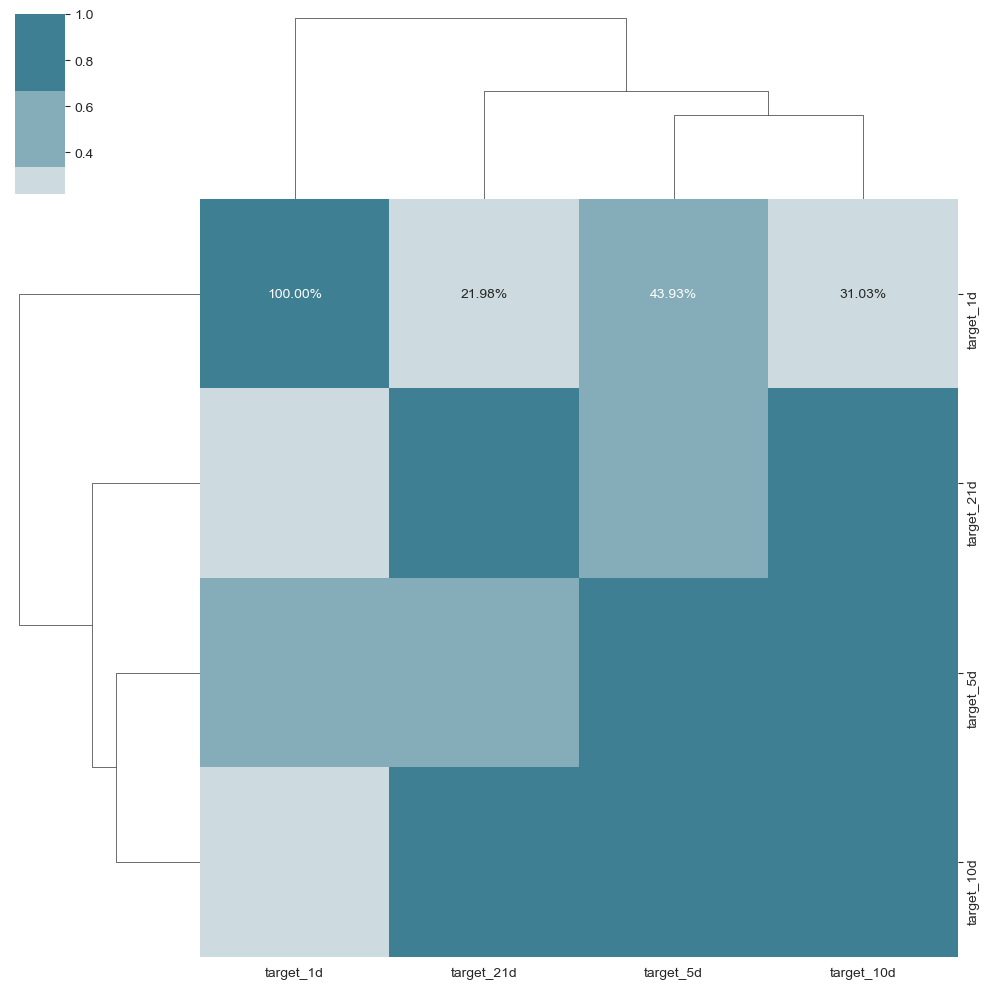

In [9]:
# Plot the correlation among the values of the regressand.
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

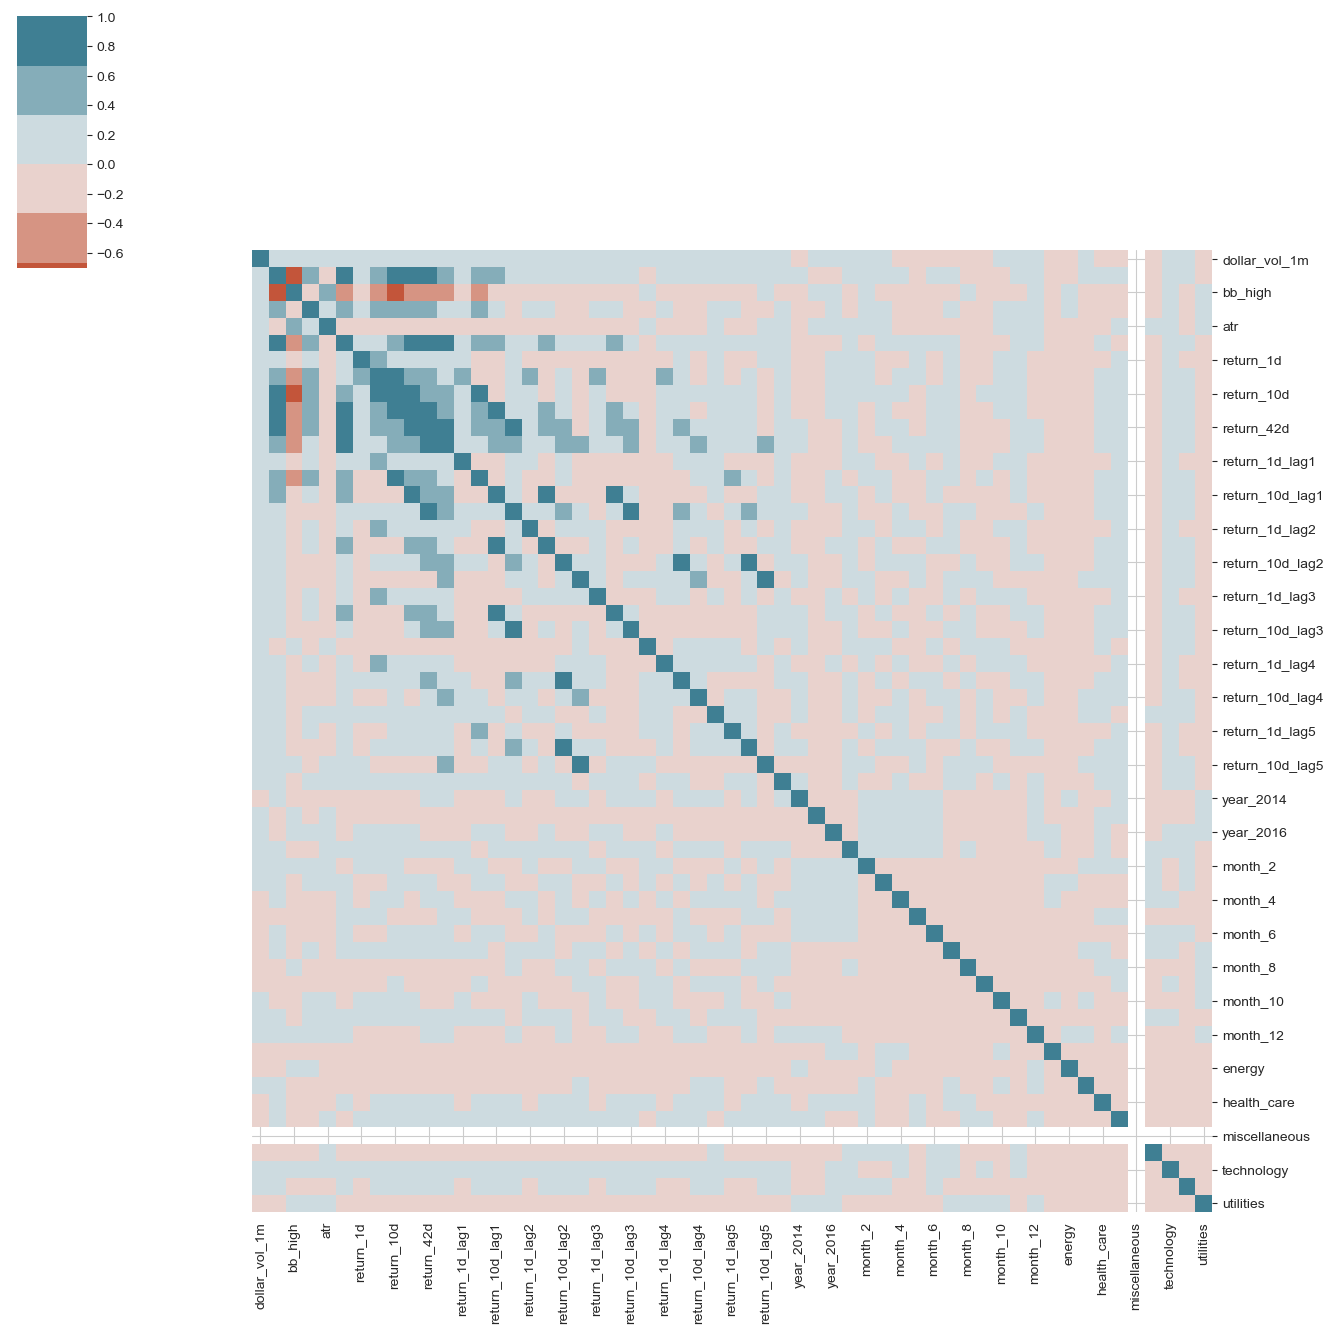

In [25]:
# Plot the correlation among the values of the regressors.
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, col_cluster=False, row_cluster=False);
plt.gcf().set_size_inches((14, 14))

In [26]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [29]:
pd.concat([corr_mat.head(), corr_mat.tail()])

,var1,var2,corr
626,return_63d,return_42d,0.829872
571,return_42d,return_63d,0.829872
61,rsi,macd,0.819103
281,macd,rsi,0.819103
509,return_21d,macd,0.813954
121,bb_high,return_21d,-0.647987
450,return_10d,bb_high,-0.701298
120,bb_high,return_10d,-0.701298
113,bb_high,rsi,-0.704404
58,rsi,bb_high,-0.704404


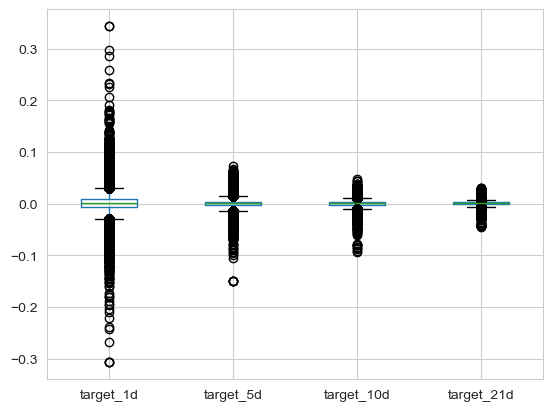

In [30]:
# Box Plot the values of the regressand.
y.boxplot();

In [31]:
# Linear Regression for Statistical Inference: OLS with statsmodels
# Ticker-wise standardization
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

In [39]:
# Run the OLS regression for 1-Day Returns
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X).astype(float))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.39
Date:                Sat, 09 Mar 2024   Prob (F-statistic):          1.27e-189
Time:                        17:17:06   Log-Likelihood:             2.9258e+05
No. Observations:              109749   AIC:                        -5.850e+05
Df Residuals:                  109692   BIC:                        -5.845e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0006   9.76

In [41]:
# Run the OLS regression for 5-Day Returns
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X).astype(float))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     66.66
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:20:22   Log-Likelihood:             3.8288e+05
No. Observations:              109749   AIC:                        -7.656e+05
Df Residuals:                  109692   BIC:                        -7.651e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0004   4.29

In [42]:
# Obtain the residuals
# add_constant() returns the original array with a constant (column of ones) as the last column.
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

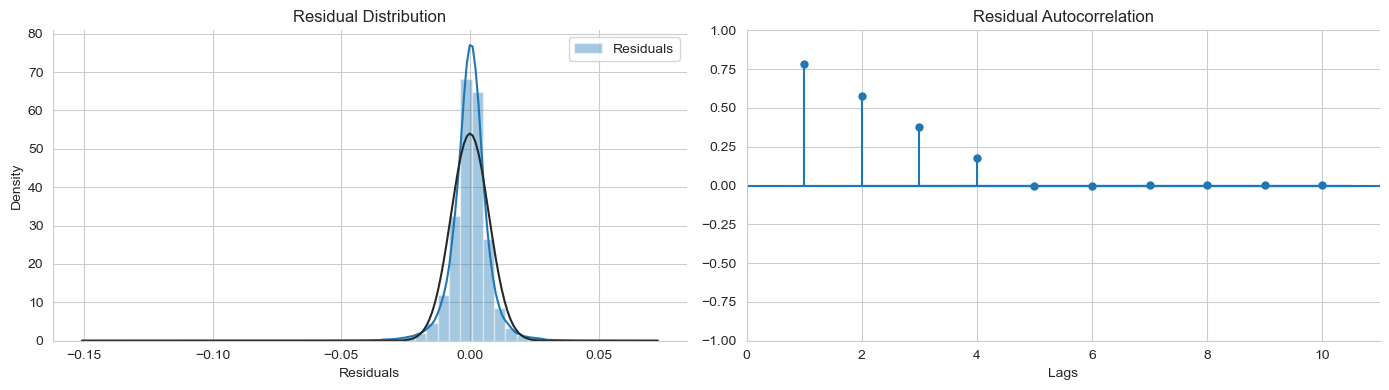

In [43]:
# Obtain the residuals
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

In [45]:
# 10-Day returns
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X).astype(float))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     93.75
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:24:14   Log-Likelihood:             4.2343e+05
No. Observations:              109749   AIC:                        -8.467e+05
Df Residuals:                  109692   BIC:                        -8.462e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0004   2.96

In [47]:
# Monthly returns
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X).astype(float))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     139.8
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:33:05   Log-Likelihood:             4.6707e+05
No. Observations:              109749   AIC:                        -9.340e+05
Df Residuals:                  109692   BIC:                        -9.335e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0004   1.99